# Analyse d'opinion

#### Objectif : créer une chaine de traitement des données textuelles sur l'analyse d'opinion

#### Jeu de données : revues de films

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
path = "movies/movies1000/"

Pour ce projet, on a souhaité proposer une méthode plus exploratoire où on développe nous-mêmes un modèle de classfication de texte, et une autre méthode où l'on essaie de prendre des modèles puissants déjà existants, présents sur étagère. (Remplace la partie optionnelle sur Word2Vec).

Dans le détail, le notebook est divisé en 3 parties :
- **Partie 1 :** Exploration des données
- **Partie 2 :** Modèle de classification de texte fait maison
- **Partie 3 :** Modèle de classification de texte avec des modèles existants (DistilBert...)

## Exploration des données

Le dossier movies est subdivisé en 2 sous-dossiers contenant les textes classifiés comme positifs et négatifs. La fonction load_files permet de charger les textes et les labels associés.

In [3]:
def load_movies(path2data):  # 1 classe par répertoire
    alltxts = []  # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data):  # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data + cl):
            txt = open(path2data + cl + "/" + f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt += 1  # chg répertoire = cht classe
    return alltxts, labs

On vérifie au préalable que le plan de l'expérience est bien équilibré. C'est le cas ici, donc pas besoin d'adopter des stratégies de rééquilibrage/pondération.

In [4]:
all_texts, all_labels = load_movies(path)

neg, pos = np.unique(all_labels, return_counts=True)[1]
print(f"Il y a {neg/(neg+pos) * 100} % de commentaires négatifs")

Il y a 50.0 % de commentaires négatifs


Dans un but premièrement purement exploratoire, je vais utiliser la librairie NLTK pour extraire les mots les plus fréquents.

Je retire les stopwords ainsi que la ponctuation pour ne garder que les mots les plus significatifs.

Le but était surtout de voir si les mots les plus fréquents étaient des mots qui avaient un sens pour moi dans le cadre de cette analyse de sentiments. Sans utiliser le filtrage sur stopwords, le registre des mots les plus fréquents est de manière intuitive très peu informatif. Dans le pipeline de traitement, il faudra donc préféréntiellement retirer les stopwords. 

On remarque que certains mots très proches comme `character` et `characters` sont comptés comme deux mots différents. Il faudra donc également faire attention à la lemmatisation des mots (stemming).

In [21]:
import nltk
import string

from nltk import bigrams, trigrams, FreqDist, word_tokenize
from nltk.corpus import stopwords

# Nécessaire pour la première exécution !!!
nltk.download("punkt")
nltk.download("stopwords")

all_texts, all_labels = load_movies(path)

text = " ".join([str(elem) for elem in all_texts])

# Retire la ponctuation
translator = str.maketrans("", "", string.punctuation)
text = text.translate(translator)

tokens = word_tokenize(text)

# Filtre les stopwords
stop_words = set(stopwords.words("english"))
tokens = list(filter(lambda token: token not in stop_words, tokens))

freq_dist = FreqDist(tokens)
vocab_size = len(freq_dist)
print(f"Taille du vocabulaire : {vocab_size}")

# Calcule les 100 bigrams et trigrams les plus fréquents
bigrams = list(bigrams(tokens))
trigrams = list(trigrams(tokens))

bigram_freq = FreqDist(bigrams)
trigram_freq = FreqDist(trigrams)

top_100_bigrams = bigram_freq.most_common(100)
top_100_trigrams = trigram_freq.most_common(100)

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Taille du vocabulaire : 47420


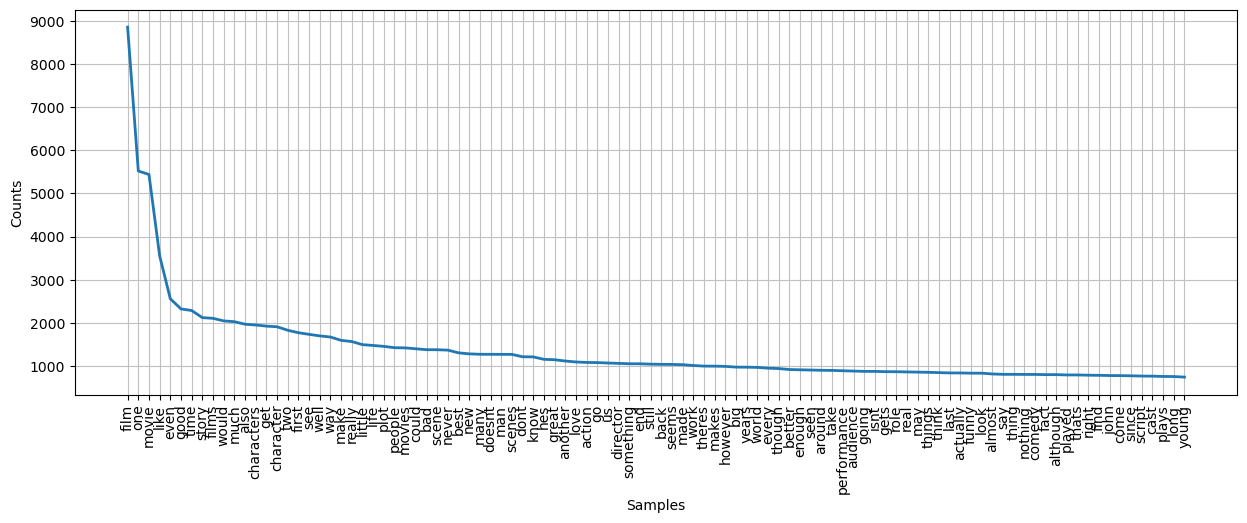

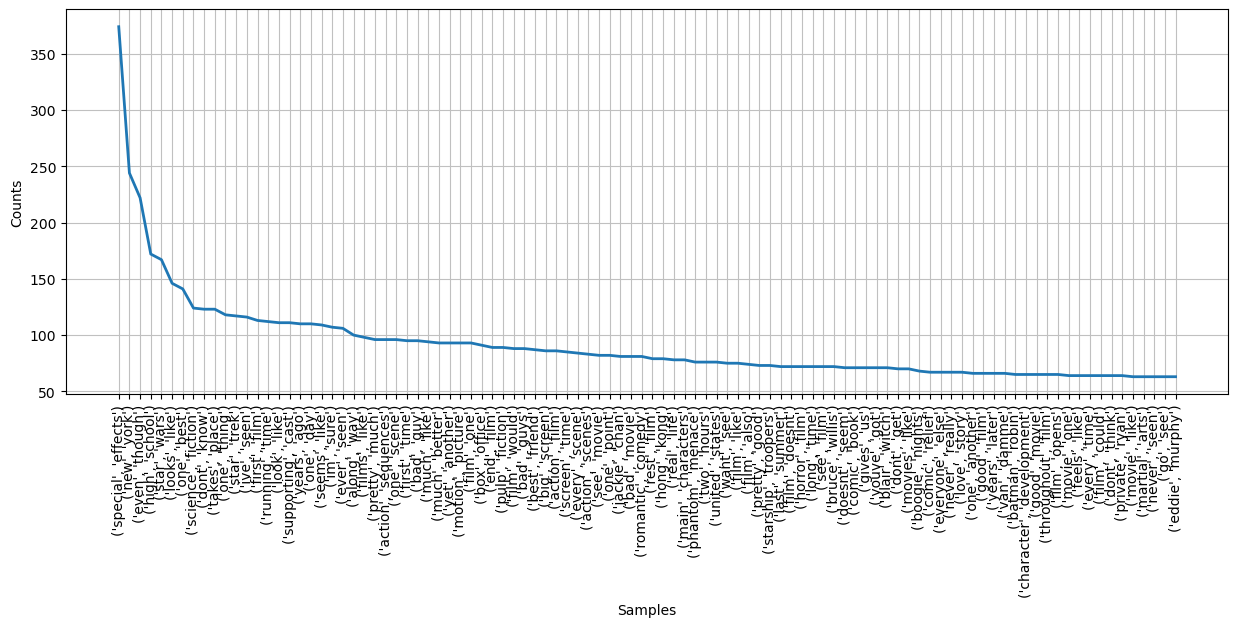

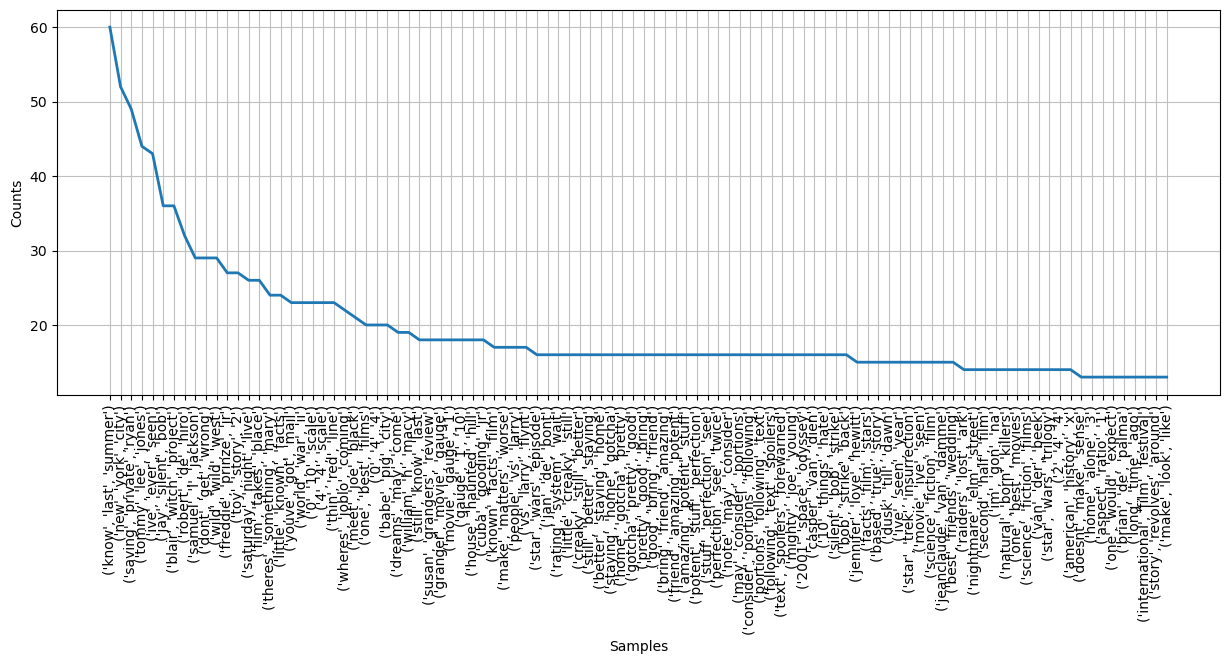

In [6]:
plt.figure(figsize=(15, 5))
freq_dist.plot(100)
plt.show()

plt.figure(figsize=(15, 5))
bigram_freq.plot(100)
plt.show()

plt.figure(figsize=(15, 5))
trigram_freq.plot(100)
plt.show()

## Modèle de classification de texte fait maison

### Architecture du modèle

On divise les données en deux parties : une partie pour l'apprentissage et une partie pour le test.

In [13]:
from sklearn.model_selection import train_test_split

all_texts, all_labels = load_movies(path)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=0
)

print("Taille de l'ensemble d'entraînement :", len(train_texts))
print("Taille de l'ensemble de test :", len(test_texts))

Taille de l'ensemble d'entraînement : 1600
Taille de l'ensemble de test : 400


Avec un dummy classifier on va poser une baseline pour notre modèle.
Si notre modèle est moins bon que le dummy classifier ou meilleur de peu, alors il ne sert à rien.

In [14]:
# make a dummy classifier always predicting the most frequent class
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_texts, train_labels)
preds = dummy_clf.predict(test_texts)
print("Accuracy:", accuracy_score(test_labels, preds))

Accuracy: 0.5


Il faut permettre au pipeline de changer de modèle, de paramètres, de pré-traitement, etc. pour trouver le meilleur modèle.

Par exemple, en première intuition on peut imaginer qu'en gardant la ponctuation il faille utiliser un bigramme/trigramme etc pour avoir de meilleures performances. Reste à le montrer. 

In [18]:
# import outils de preprocessing
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# import models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from functools import partial
from unidecode import unidecode


def preprocess(text, remove_punctuation=True, use_stemming=True, remove_stopwords=True):
    # En anglais, à priori les accents et autres caractères spéciaux ne sont très utiles
    # dans ce contexte, je normalise donc le texte
    text = text.lower()
    text = unidecode(text)

    tokens = nltk.word_tokenize(text)

    if remove_punctuation:
        tokens = [token for token in tokens if token not in string.punctuation]

    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens = [token for token in tokens if token not in stop_words]

    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)


with_punctuation = partial(preprocess, remove_punctuation=False)

# Définir une pipeline avec différentes étapes de pré-traitement
pipeline = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                preprocessor=preprocess,
                ngram_range=(1, 1),
            ),
        ),
        ("tfidf", TfidfTransformer()),
        ("clf", SVC()),
    ]
)

Je vérifie que le pré-traitement fonctionne bien sur des exemples simples:

Les mots sont bien lemmatisés, les stopwords sont bien retirés, la ponctuation est bien retirée/gardée selon le paramètre.

In [20]:
from functools import partial

# partial me permet de créer une fonction qui appelle preprocess avec certains paramètres

without_punctuation = partial(preprocess, remove_punctuation=True)
sample_text = "This is a sample text, with punctuation, accents comme à l'époque  !"
print(f"Text with punctuation: {sample_text}")
print(f"Text without punctuation: {without_punctuation(sample_text)}")

Text with punctuation: This is a sample text, with punctuation, accents comme à l'époque  !
Text without punctuation: sampl text punctuat accent comm l'epoqu


In [21]:
from sklearn.metrics import accuracy_score

pipeline.fit(train_texts, train_labels)
predictions = pipeline.predict(test_texts)
accuracy = accuracy_score(test_labels, predictions)

print("Précision du modèle :", accuracy)

Précision du modèle : 0.86


### Evaluation du modèle

Comme il existe de nombreux paramètres, pour faire une comparaison pertinente je préfère sélectionner certains paramètres à investiguer plus que d'autres au fur et à mesure que j'avance dans l'analyse.

#### Famille de modèles

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import pandas as pd

# Définir les modèles à tester
models = [
    ("dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()),
    ("Logistic Regression", LogisticRegression()),
    ("Gradient Boosting", GradientBoostingClassifier()),
]

# Définir les pipelines à tester
pipelines = [
    Pipeline(
        [
            (
                "vect",
                CountVectorizer(
                    preprocessor=preprocess,
                    ngram_range=(1, 1),
                ),
            ),
            ("tfidf", TfidfTransformer()),
            ("clf", model),
        ]
    )
    for _, model in models
]

models += [("SVM (without TF-IDF)", SVC())]
pipelines += [
    Pipeline([("vect", CountVectorizer(preprocessor=preprocess)), ("clf", SVC())])
]

# Définir les scores à utiliser
scoring = ["accuracy", "f1_macro"]
kfold = KFold(n_splits=5, shuffle=True, random_state=0)


In [ ]:

# Calculer les scores pour chaque pipeline (f1 et accuracy) pour en faire
# un boxplot ensuite
scores_model = []

for pipeline, (name, _) in zip(pipelines, models):
    print(f"Calcul des scores pour {name}")
    results = cross_validate(
        pipeline,
        all_texts,
        all_labels,
        cv=kfold,
        scoring=scoring,
        return_train_score=True,
    )
    for score in scoring:
        for fold in range(5):
            scores_model.append(
                {
                    "score": results[f"test_{score}"][fold],
                    "train_score": results[f"train_{score}"][fold],
                    "fold": fold,
                    "model": name,
                    "score_name": score,
                }
            )

In [11]:
import seaborn as sns


def plot_scores(scores, modalites):
    df = pd.DataFrame(scores)

    accuracy = df[df["score_name"] == "accuracy"]
    f1 = df[df["score_name"] == "f1_macro"]

    accuracy.boxplot(column="score", by="model", figsize=(12, 6))
    plt.title(f"Boxplot de l'Accuracy par {modalites}")
    plt.suptitle("")
    plt.savefig(f"figures/boxplot_accuracy_{modalites}.png")
    plt.show()

    f1.boxplot(column="score", by="model", figsize=(12, 6))
    plt.title(f"Boxplot du F1 par {modalites}")
    plt.suptitle("")
    plt.savefig(f"figures/boxplot_f1_{modalites}.png")
    plt.show()

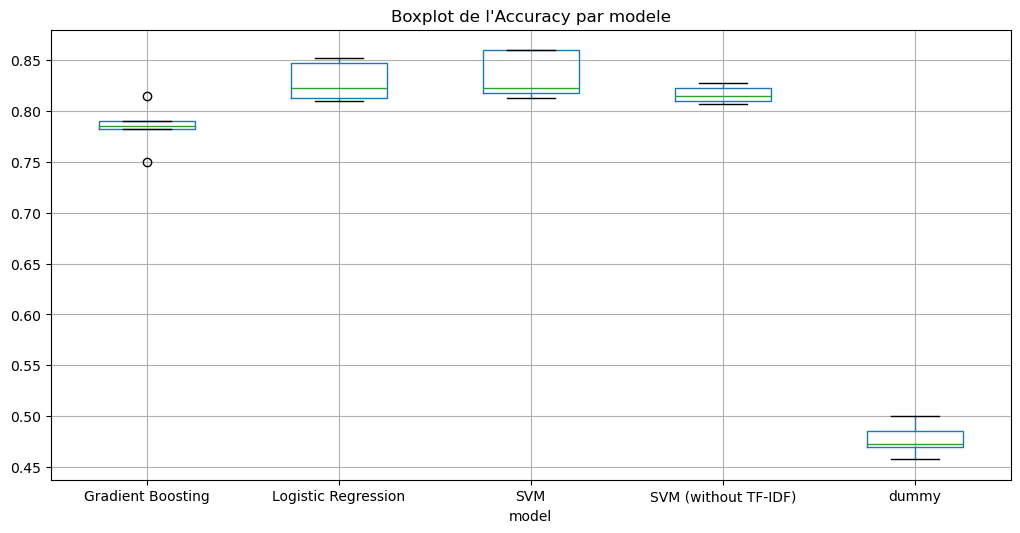

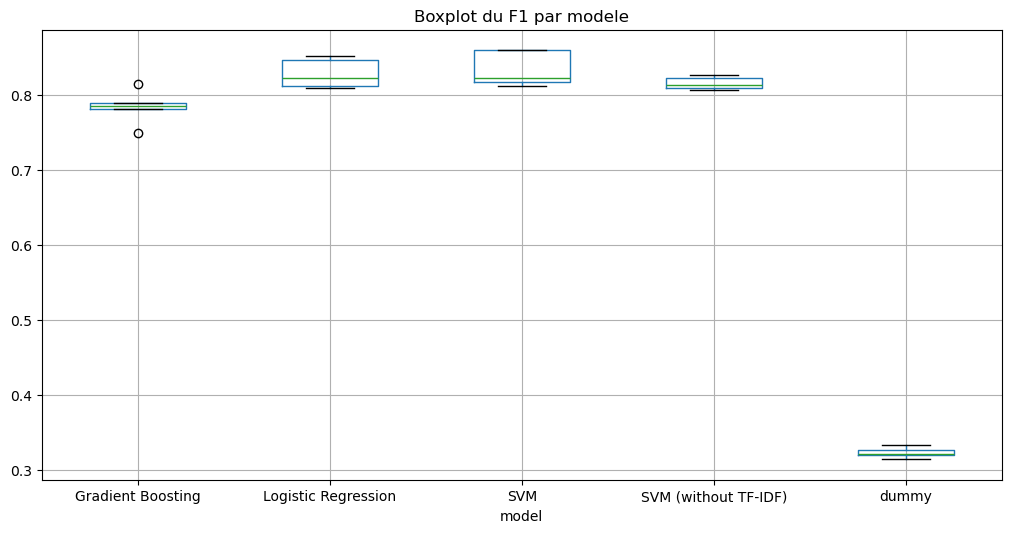

In [14]:
plot_scores(scores_model, "modele")

Le SVM avec TF-IDF a des performances très bonnes, avec les quartiles plus proches de la moyenne que les autres, quasi similairement avec la logistic regression. Assez étonnement le gradient boosting sous performe. Il faudrait dans l'idéal se renseigner dans la littérature s'il est nécessaire d'ajouter une étape dans le pipeline pour améliorer ses performances.

Au vu de la moyenne et de la dispersion des performances, je vais me concentrer sur le SVM pour les prochaines étapes.

#### Influence du preprocessing

In [12]:
keep_punctuation = partial(preprocess, remove_punctuation=False)
keep_stopwords = partial(preprocess, remove_stopwords=False)
without_stemming = partial(preprocess, use_stemming=False)
quasi_non_preprocess = partial(
    preprocess, remove_punctuation=False, remove_stopwords=False, use_stemming=False
)

# Définir les modèles à tester
model = SVC()
preprocessors = [
    ("SVM with all", preprocess),
    ("SVM (without extra preprocessing)", quasi_non_preprocess),
    ("SVM (keep punctuation)", keep_punctuation),
    ("SVM (keep stopwords)", keep_stopwords),
    ("SVM (without stemming)", without_stemming),
]

# Définir les pipelines à tester
pipelines = [
    Pipeline(
        [
            (
                "vect",
                CountVectorizer(
                    preprocessor=preprocessor,
                    ngram_range=(1, 1),
                ),
            ),
            ("tfidf", TfidfTransformer()),
            ("clf", model),
        ]
    )
    for _, preprocessor, in preprocessors
]

# Définir les scores à utiliser
scoring = ["accuracy", "f1_macro"]
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

NameError: name 'KFold' is not defined

In [ ]:

# Calculer les scores pour chaque pipeline (f1 et accuracy) pour en faire
# un boxplot ensuite
scores_preprocessor = []

for pipeline, (name, _) in zip(pipelines, preprocessors):
    print(f"Calcul des scores pour {name}")
    results = cross_validate(
        pipeline,
        all_texts,
        all_labels,
        cv=kfold,
        scoring=scoring,
        return_train_score=True,
    )
    for score in scoring:
        for fold in range(5):
            scores_preprocessor.append(
                {
                    "score": results[f"test_{score}"][fold],
                    "train_score": results[f"train_{score}"][fold],
                    "fold": fold,
                    "model": name,
                    "score_name": score,
                }
            )

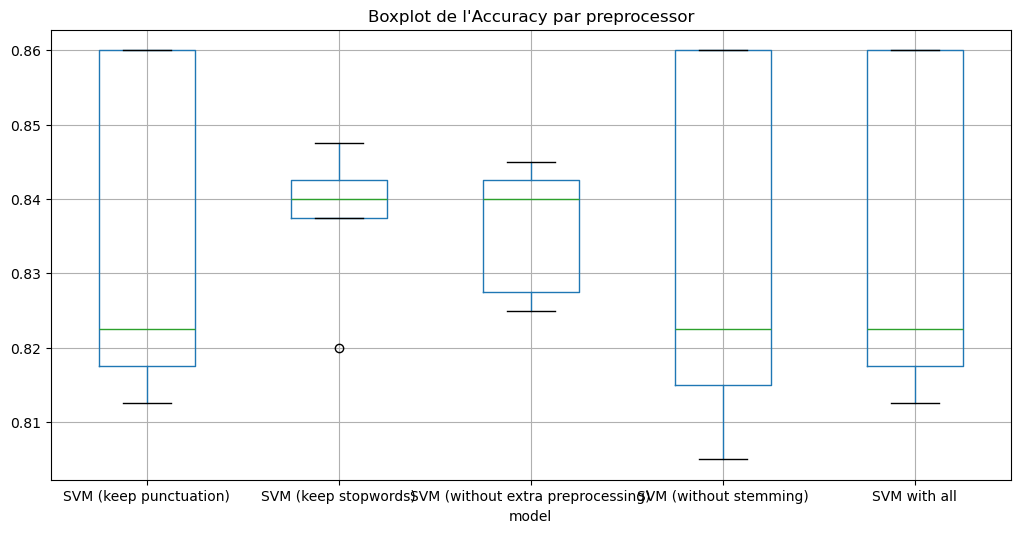

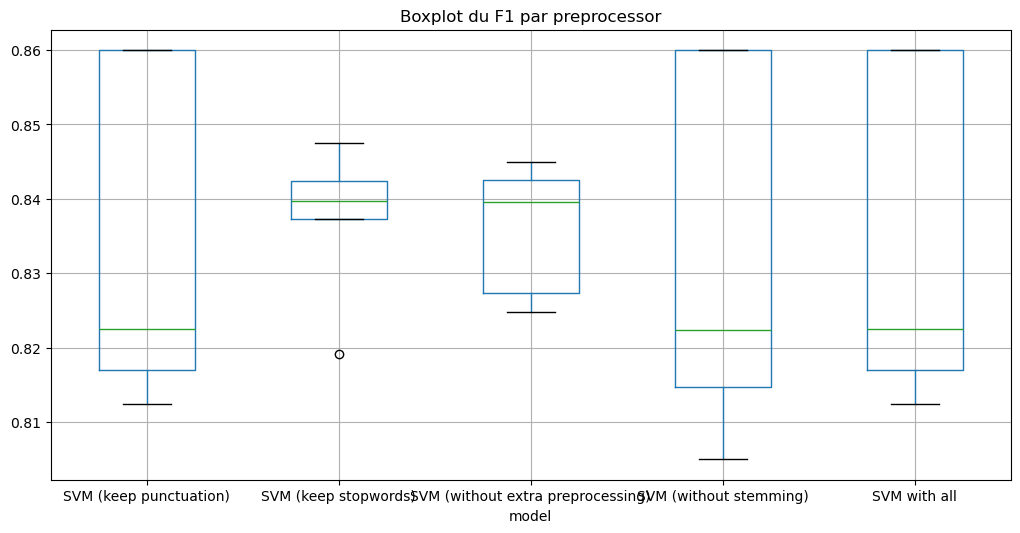

In [16]:
plot_scores(scores_preprocessor, "preprocessor")

On constate que dans notre cas retirer le stemming peut être marginalement bénéfique. 

Ce résultat dénote surtout de l'importance des stopwords dans notre cas d'usage, **il semble que cela soit le paramètre le plus important à prendre en compte**. En effet, sans retirer les stopwords uniquement, les performances sont très proches de celles obtenues sans pré-traitement (hormis normaliser les accents et caractères spéciaux).

La moyenne est plus élevée dans ces conditions, et la dispersion est plus faible. Les valeurs minimales sont également plus élevées mais les maximales sont plus basses.  

Il y aurait donc **deux stratégies possibles** si l'on souhaite améliorer les performances :
* Compter sur des performances plus stables en gardant les stopwords, mais avec des performances maximales éventuellement plus basses.
* Compter sur des performances maximales plus élevées en retirant les stopwords, mais avec des performances plus instables.



**Ces résultats dépendent probablement fortement du ngrams**, seulement le temps de calcul est relativement conséquent. J'ai donc fait ces tests pour chacun des modèles à côté et pas sur la procédure centrale. Dans la cellule suivante je l'ai fait pour le SVM without stemming.


Par exemple, avec tous les prétraitements et sans faire de cross validation :

In [17]:
scores_ngrams = []

for i in range(3):
    pipeline = Pipeline(
        [
            (
                "vect",
                CountVectorizer(
                    preprocessor=without_stemming,
                    ngram_range=(1, i + 1),
                ),
            ),
            ("tfidf", TfidfTransformer()),
            ("clf", SVC()),
        ]
    )

    results = cross_validate(
        pipeline,
        all_texts,
        all_labels,
        cv=kfold,
        scoring=scoring,
        return_train_score=True,
    )

    for score in scoring:
        for fold in range(5):
            scores_ngrams.append(
                {
                    "score": results[f"test_{score}"][fold],
                    "train_score": results[f"train_{score}"][fold],
                    "fold": fold,
                    "model": f"SVM (without stemming) - {i+1}grams",
                    "score_name": score,
                }
            )

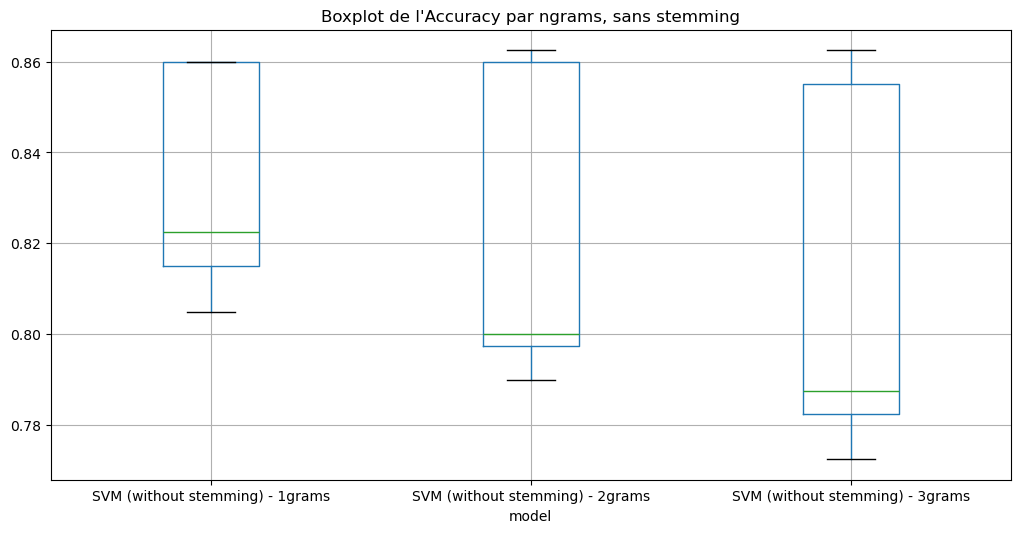

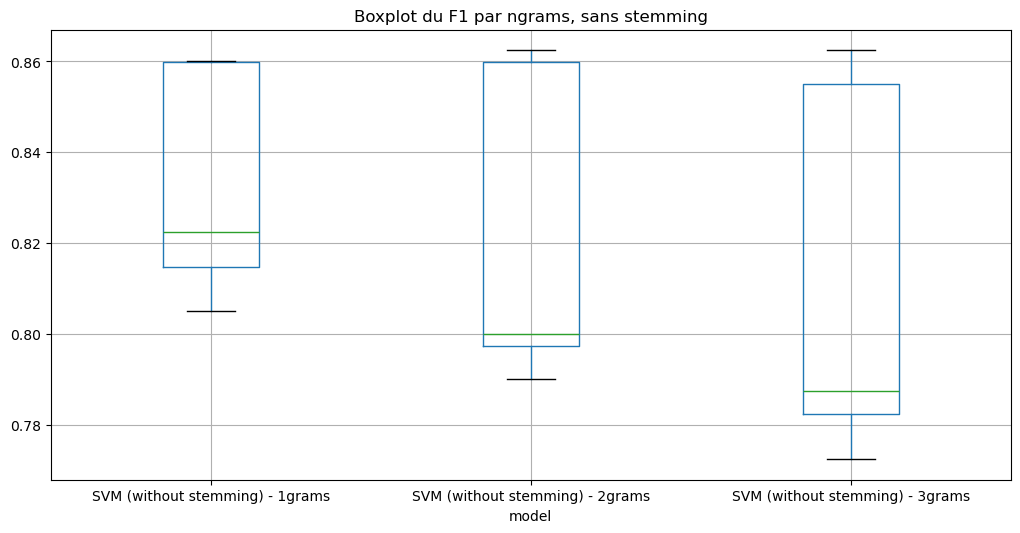

In [18]:
plot_scores(scores_ngrams, "ngrams, sans stemming")

Sur l'ensemble des fonctions précédemment citées, on constate une diminution des performances moyennes en augmentant les ngrams. Cela s'explique peut-être par le fait que plus les ngams sont grands, plus les mots sont rares et donc plus il est difficile de trouver des similarités entre les textes. 

En effet, dans la première partie on constate qu'il y a une chute brutale du nombre de mots dans le vocabulaire lorsque l'on passe de unigram à bigram (facteur de l'ordre 20) et de bigram à trigram (facteur de l'ordre 10).
Or le vocabulaire est probablement trop petit pour que les ngrams soient pertinents dans notre cas.

### Optimisation des hyperparamètres

Au lieu d'utiliser un gridsearch, on va passer par le TPE (Tree-structured Parzen Estimator) qui est un algorithme d'optimisation bayésienne. Il est implémenté dans la librairie optuna en paramètre par défaut.

Comme il y énormément de calculs à réaliser, on va paralléliser les cross validations. On compare les scores au regard de l'accuracy.

Optuna permet aussi de stocker les essais dans une base de données, et donc analyser à posteriori quels paramètres sont les moins intéressants, etc.

In [19]:
import optuna
from joblib import parallel_backend

from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline

from functools import partial

keep_stopwords = partial(preprocess, remove_stopwords=False)
without_stemming = partial(preprocess, use_stemming=False)

def objective(trial):
    # Définir l'espace de recherche
    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)

    # Créer le pipeline
    pipeline = Pipeline([
        ("vect", CountVectorizer(preprocessor=keep_stopwords, ngram_range=(1, 1))),
        ("tfidf", TfidfTransformer()),
        ("clf", SVC(C=C, kernel=kernel, gamma=gamma))
    ])
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    # Calculer le score de validation croisée
    with parallel_backend('threading', n_jobs=1):
        score = cross_val_score(pipeline, all_texts, all_labels, cv=kfold, scoring='accuracy').mean()

    return score

# Créer un study Optuna
study = optuna.create_study(direction='maximize', study_name='my_study', storage='sqlite:///study_keep_stopwords.db', load_if_exists=True)

# Exécuter l'optimisation
study.optimize(objective, n_trials=20, n_jobs=1)

# Afficher les meilleurs hyperparamètres
print('Best hyperparameters: ', study.best_params)

[I 2024-01-13 22:50:00,954] Using an existing study with name 'my_study' instead of creating a new one.
/tmp/ipykernel_27861/551945866.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-10, 1e10)
/tmp/ipykernel_27861/551945866.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)
[W 2024-01-13 22:50:01,185] Trial 46 failed with parameters: {'C': 142096.7166087615, 'kernel': 'rbf', 'gamma': 5.138394193230868e-06} because of the following error: ValueError('\nAll the 5 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting erro

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/codespace/.local/lib/python3.10/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py", line 1389, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py", line 1276, in _count_vocab
    for feature in analyze(doc):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py", line 110, in _analyze
    doc = preprocessor(doc)
  File "/tmp/ipykernel_27861/1267416906.py", line 26, in preprocess
    tokens = nltk.word_tokenize(text)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/nltk/tokenize/__init__.py", line 129, in word_tokenize
    sentences = [text] if preserve_line else sent_tokenize(text, language)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/nltk/tokenize/__init__.py", line 106, in sent_tokenize
    tokenizer = load(f"tokenizers/punkt/{language}.pickle")
  File "/home/codespace/.python/current/lib/python3.10/site-packages/nltk/data.py", line 750, in load
    opened_resource = _open(resource_url)
  File "/home/codespace/.python/current/lib/python3.10/site-packages/nltk/data.py", line 876, in _open
    return find(path_, path + [""]).open()
  File "/home/codespace/.python/current/lib/python3.10/site-packages/nltk/data.py", line 583, in find
    raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/codespace/nltk_data'
    - '/home/codespace/.python/current/nltk_data'
    - '/home/codespace/.python/current/share/nltk_data'
    - '/home/codespace/.python/current/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************



Pour être honnête, je suis un peu déçu des résultats. Je m'attendais à ce que le TPE trouve des paramètres plus intéressants que ceux choisi par défaut. Mais c'était en réalité prévisible, l'espace de recherche est trop grand pour que l'optimiseur soit efficace en une quarantaine d'essais (soit déjà un run time **qui se compte en heures** sur ma machine).

J'ai appliqué l'optimisation sur le without stemming ET le keeping stopwords, cf l'explication précédente.

In [28]:
kwargs_keep_stopwords = {'C': 1209285037.3395557, 'kernel': 'poly', 'gamma': 1.5377771830749824e-08}

In [32]:
kwargs_without_stemming = {'C': 54215643.877954505, 'kernel': 'rbf', 'gamma': 0.2085574967665132}

pipeline = Pipeline([
    ("vect", CountVectorizer(preprocessor=without_stemming, ngram_range=(1, 1))),
    ("tfidf", TfidfTransformer()),
    ("clf", SVC(**kwargs_without_stemming, verbose=True))
])

pipeline.fit(train_texts, train_labels)
predictions = pipeline.predict(test_texts)
accuracy = accuracy_score(test_labels, predictions)

print("Accuracy du modèle :", accuracy)

[LibSVM]..*.*
optimization finished, #iter = 3015
obj = -1723.296391, rho = -0.075717
nSV = 1477, nBSV = 0
Total nSV = 1477
Accuracy du modèle : 0.8425


Finalement, les résultats étaient assez variants. Que cela soit avec la seed utilisée ou simplement la version de sklearn (quand je travaillais en VM) les résultats étaient très différents.

Aussi, on constate qu'effectivement plus un modèle prend de temps à s'entrainer, plus il est important de bien poser son plan d'expérience afin d'éviter de perdre du temps à tester des paramètres qui n'ont pas/peu d'influence sur les performances.

In [38]:
# Appliquer le modèle le fichier de test qui ne contient que les phrases
# Puis sauvegarder les prédictions dans un fichier texte
from tqdm import tqdm

# Ouverture du fichier de test
with open('movies/testSentiment.txt', 'r') as f:
    # Lecture des lignes
    lines = f.readlines()
    # Retirer le retour à la ligne (\n)
    lines = [line.strip() for line in lines]

predictions = []

# Prédictions
# En utilisant tqdm on empeche à priori la parallélisation
# Mais on peut voir la progression de la boucle...
for line in tqdm(lines):
    prediction = pipeline.predict([line])
    predictions.append(prediction[0])

# Sauvegarde des prédictions
with open('results/predictions_SVM.txt', 'w') as f:
    for prediction in predictions:
        f.write(f'{prediction}\n')

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [02:03<00:00, 203.04it/s]


## Modèle de classification de texte avec des modèles existants

In [7]:
!pip install torch torchvision torchaudio
!pip install accelerate
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.1.1
    Uninstalling torch-2.1.1:
      Successfully uninstalled torch-2.1.1

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [10]:
import os
path = "movies/movies1000/"

def load_movies(path2data):  # 1 classe par répertoire
    alltxts = []  # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data):  # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data + cl):
            txt = open(path2data + cl + "/" + f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt += 1  # chg répertoire = cht classe
    return alltxts, labs

### Comparaison avec un modèle pré-entraîné sur IMDB

Intuitivement, je me suis fait la remarque que prendre un modèle pré-entrainé sur des données de films pourrait être une bonne solution. En effet, cela déporte la charge de l'entrainement sur d'autres, et je prends un modèle pertinent sur l'étagère. Dans ce premier temps je ne vais pas fine-tuner le modèle car **il se trouve qu'il est entrainé en partie sur ce dataset**.

Dans le détail, certains des textes du test ne sont pas présents dans le dataset. D'autres le sont. D'après mes recherches au doigt mouillé.  

On peut tester rapidement le fonctionnement de ce modèle trouvé sur huggingface :

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
sentence = "This movie is fantastic!"
result = classifier(sentence)

print(result)

[{'label': 'POSITIVE', 'score': 0.9944781064987183}]


Maintenant, je cherche à l'appliquer sur les données chargées avec load_movies. Apparemment il faut passer par autre chose que l'objet haut niveau pipeline, et utiliser les bindings PyTorch/TensorFlow

In [7]:
import torch
from torch.nn.functional import softmax

# Phrase à prédire
sentence = "This movie is fantastic!"

# Tokenisation de la phrase
inputs = tokenizer(sentence, return_tensors="pt")

# Obtention des logits de prédiction
outputs = model(**inputs)

# Conversion des logits en probabilités
probs = softmax(outputs.logits, dim=1)

# Obtention de la classe prédite
predicted_class = torch.argmax(probs).item()

print(f"Classe prédite : {predicted_class} proba {probs[0, predicted_class].item()}")

Classe prédite : 1 proba 0.9944781064987183


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

all_texts, all_labels = load_movies(path)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=0
)

# Prédiction des labels pour les textes de test
test_preds = []
for text in tqdm(test_texts):
    inputs = tokenizer(text, truncation=True, max_length=512, padding='max_length', return_tensors="pt")
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs).item()
    test_preds.append(predicted_class)

# Calcul du score de précision
accuracy = accuracy_score(test_labels, test_preds)

print(f"Le score de précision est : {accuracy}")

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [02:14<00:00,  2.98it/s]

Le score de précision est : 0.9175


Le score de précision est de 0.9175 sur la validation. Soit un score très proche de celui obtenu avec le SVM sans stemming. Il y a un delta de 0.0475. 

In [41]:
# Ouverture du fichier de test
with open('movies/testSentiment.txt', 'r') as f:
    lines = f.readlines()

results = []
# Utilisation de tqdm pour avoir une barre de progression
for line in tqdm(lines):
    inputs = tokenizer(line, truncation=True, max_length=512, padding='max_length', return_tensors="pt")
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs).item()
    proba = probs[0, predicted_class].item()
    results.append((predicted_class, proba))

# Écriture des résultats dans un autre fichier texte
with open('results/prediction_pretrained.txt', 'w') as f:
    for result in results:
        f.write(f"{result[0]}\n")

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [2:12:21<00:00,  3.15it/s]  


### Comparaison avec un modèle non entraîné sur IMDB, fine-tuné

Dans les faits, on n'a pas souvent un modèle pré-entrainé sur les données que l'on veut classifier. Il paraît donc plus représentatif de fine-tuner un modèle généraliste.

In [2]:
from sklearn.model_selection import train_test_split

all_texts, all_labels = load_movies(path)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=0
)

In [3]:
from transformers import Trainer, TrainingArguments, AutoTokenizer
from transformers import DistilBertForSequenceClassification
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score

# Tokenizer &
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Création d'une classe Dataset
class MovieReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': sanencoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

trainer = Trainer(
    model=model.to('cuda'),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
# Création des datasets
train_dataset = MovieReviewDataset(train_texts, train_labels, tokenizer)
test_dataset = MovieReviewDataset(test_texts, test_labels, tokenizer)

# Définition des arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Création du Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Entraînement du modèle
trainer.train()

# Évaluation du modèle
trainer.evaluate()

# Sauvegarde du modèle
trainer.save_model("distilbert-custom-fine-tune-imdb")

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


: 

Malheureusement, je n'ai pas pu faire tourner le modèle sur mon ordinateur ni sur le Github Workspace probablement car il n'y a pas de GPU. Le kernel ne faisait que crasher. En passant par Google colab en revanche, cela fonctionne !

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Obtenir les prédictions
predictions = trainer.predict(test_dataset)

# Les prédictions sont dans un tableau à 2 dimensions, prenez l'indice de la valeur maximale pour obtenir les prédictions finales
preds = np.argmax(predictions.predictions, axis=-1)

# Calculer l'accuracy
accuracy = accuracy_score(test_labels, preds)

print(f'Accuracy: {accuracy}')

**J'ai obtenu une Accuracy de 0.8275**, un résultat inférieur à ce que l'on obtient avec le SVM. Cela s'explique surement par la petite taille du set d'entrainement pour le fine-tuning. Il faudrait donc augmenter la taille du set d'entrainement pour avoir de meilleures performances.

In [ ]:
# Ouverture du fichier de test
with open('movies/testSentiment.txt', 'r') as f:
    lines = f.readlines()
model.to('cuda')
results = []
# Utilisation de tqdm pour avoir une barre de progression
for line in tqdm(lines):
    # Déplacement des entrées sur le GPU
    inputs = tokenizer(line, truncation=True, max_length=512, padding='max_length', return_tensors="pt")
    inputs = {name: tensor.to('cuda') for name, tensor in inputs.items()}
    
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs).item()
    proba = probs[0, predicted_class].item()
    results.append((predicted_class, proba))

# Écriture des résultats dans un autre fichier texte
with open('results/prediction_finetuned_bert.txt', 'w') as f:
    for result in results:
        f.write(f"{result[0]}\n")

## Conclusion

Sur la validation (test_set) sans cross validation, on obtient les résultats suivants :

| Modèle | Accuracy sur la validation |
|--------|-----------------------------|
| SVM    | 0.87  |
| Modèle pré-entrainé | 0.9175 |
| Modèle généraliste fine-tuné | 0.8275 (*) |

Le modèle SVM s'en sort très bien. En revanche, il a nécessité plus de travail temps pour optimiser et choisir les paramètres. Mais on gagne en flexibilité et en compréhension du modèle car il reste très simple.

En comparaison, une fois que l'on sait comment utiliser les modèles pré-entrainés, on peut obtenir en quelques lignes de code des résultats très satisfaisants. Ils nécessitent également d'avoir suffisamment de données pour fine-tuner le modèle, ce qui se traduit par des temps de calculs plus longs, un stockage du modèle plus important (250 Mo rien que pour ça !!).

Je considère évidemment que le modèle pré-entrainé sur IMDB est un peu de la triche car il y a un recoupement des données. En revanche, le modèle fine-tuné est plutôt performant sachant qu'il n'y a eu aucune tentative de trouver le meilleur set de paramètres. 

**REMARQUE**: (*) En faisant tourner le modèle plusieurs fois, j'ai obtenu des résultats très variables, à chaque fois inférieurs à 0.8275. On s'attend donc que la généralisation au test soit vraiment moins bonne que le SVM et le modèle pré-entrainé sur IMDB.